In [39]:
import clip
from fastai.vision.all import *

import pandas as pd

import glob
import newlinejson
import PIL
from helper import *

In [3]:
def new_resnet(pretrained):
    '''
    fix for cnn_learner module using non-standard pre-trained models
    '''
    return default_res50

def make_prediction(path, topk=5):
    output_ = {}
    label, y, output = learner.predict(path)
    probs, preds = output.topk(5)
    for index, class_ in enumerate(preds):
        output_[classes[class_]] = round(float(probs[index]),4)
    return output_



def make_prediction(data, path, topk=2):
    output_ = {}
    
    # make places predictions
    label, y, output = learner.predict(path)
    output_places = output.numpy()
    output_places = np.expand_dims(output_places, axis=0)

    
    # make clip predictions
    img_features = get_single_img_features(path)
    output_clip = CLIP_model.predict_proba(img_features)
    
    # soft averaging
    avg = np.average([output_places, output_clip], axis=0)
    
    # select top-k
    topk = topk * -1
    
    best_n = np.argsort(avg, axis=1)[:,topk:]
    probabilities = np.round(np.sort(avg, axis=1)[:,topk:], 2)
    labels = [data.vocab[i] for i in best_n]
    
    for i, _ in enumerate(probabilities[0]):
        output_[labels[0][i]] = probabilities[0][i]
    return output_

In [10]:
!ls ../

data  hisvis  notebooks


In [25]:
# setting path variables 
Path.BASE_PATH = Path('../../DeBoer_Train')
Path.BASE_PATH.ls()
path = Path.BASE_PATH

In [12]:
data = get_dls(128, 224, path, augment=False)
classes = data.vocab

/opt/conda/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [13]:
classes

['akker', 'amfitheater', 'aula', 'auto', 'auto_ongeluk', 'bakkerij', 'basketbal_korfbal', 'begraafplaats', 'begrafenis', 'bibliotheek_boekwinkel', 'binnen_zwembad', 'bloemen', 'bloementuin', 'boksen', 'borden_gevelsteen', 'bos_park', 'boten', 'bouwplaats', 'brand', 'brug', 'bruiloft', 'buiten_zwembad', 'bus_truck', 'cafe', 'catwalk', 'circus', 'cricket', 'dansende_mensen', 'demonstratie', 'dieren_overig', 'duinen', 'eend', 'etalage', 'etende_mensen', 'fabriek', 'fietsende_mensen', 'garage_showroom', 'gebouw', 'geestelijken', 'groepsportret', 'gymnastiek', 'handbal', 'hardlopen', 'haven', 'herdenking', 'historisch_toneelstuk', 'hockey', 'hond', 'honkbal', 'huisje', 'kaartspel', 'kade', 'kamperen', 'kantoor', 'kapper', 'kerk_binnen', 'kerk_buiten', 'kermis', 'kerstmis', 'keuken', 'klaslokaal', 'koe', 'konijn', 'kunstwerk', 'luchtfoto', 'maquette', 'markt', 'mensen_op_een_boot', 'mensen_op_trap', 'mensenmassa', 'militair', 'motorfiets', 'muziek_optreden', 'ongeluk_brancard', 'ontvangst_af

In [14]:
test_img = '../../DeBoer_Train/basketbal_korfbal/NL-HlmNHA_1478_09288_G.jpg'

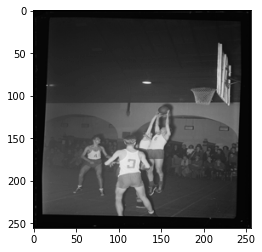

In [15]:
img = Image.open(test_img)
img = img.resize((256, 256))

plt.imshow(img, cmap='gray')

## Make predictions with Fine-Tuned Places-365 Model

In [16]:
learner = load_learner('./models/DeBoer_places.pkl')

In [17]:
label, y, output = learner.predict(test_img)

In [18]:
probs, preds = output.topk(5)
output_ = {}

top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)

In [19]:
for index, class_ in enumerate(preds):
    output_[classes[class_]] = round(float(probs[index]),4)

In [20]:
output_

{'basketbal_korfbal': 0.9368,
 'hardlopen': 0.0134,
 'zeepkistenrace': 0.0049,
 'auto': 0.0033,
 'voetbal': 0.0032}

## Make Prediction with CLIP-Linear Probe

In [21]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 28.9MiB/s]


In [ ]:
img_dir = '../../MelvinWevers#9512/wereldculturen/data'

files = get_image_files(img_dir)
files[0]

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [26]:

dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(Path('speech/NL-HlmNHA_1478_3988.jpg'), 'speech')

AttributeError: 'Tensor' object has no attribute 'read'

In [76]:
new_labels = ['a photograph taken indoors', 'a photograph taken outdoors']
dutch_labels = ['binnen', 'buiten']

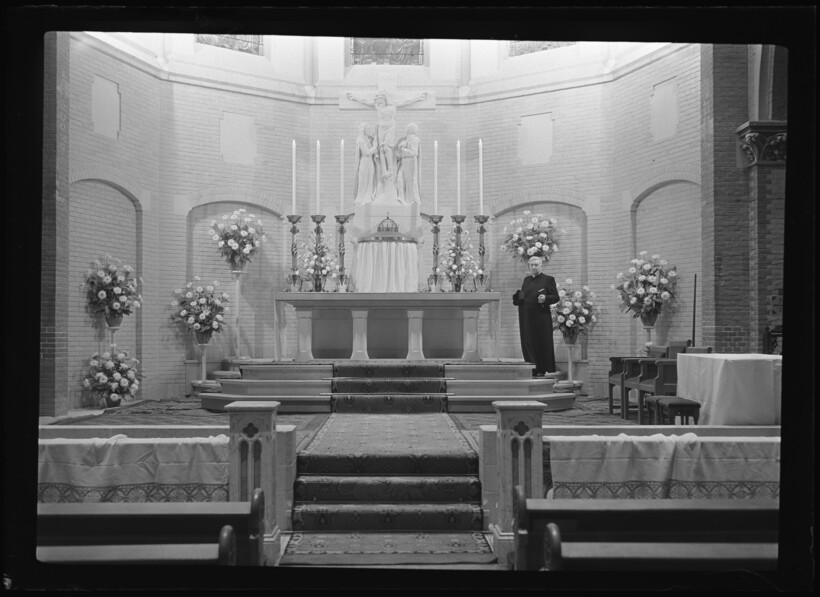

In [57]:
image, label = dsets.train[25]
PIL.Image.open(image).convert('RGB')

In [88]:


def clip_predict(text_features, img_path, k=2):
    output_ = {}
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image)
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(k)
    
    for i, _ in enumerate(values):
        output_[dutch_labels[i]] = np.round(values[i].item(), 2)

    return output_
    

In [59]:
# Pick the top 5 most similar labels for the image


# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{new_labels[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

a photograph taken indoors: 97.31%
a photograph taken outdoors: 2.68%


In [77]:
output_ = {}


{'binnen': 0.97, 'buiten': 0.03}

In [78]:
imgs = glob.glob('../../sample_images/HisVis2/**/*.jpg')

In [82]:
df = pd.read_csv('../data/20210705_random_images_metadata.csv')

In [93]:
results = list()
counter = 1

text = clip.tokenize(new_labels).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)

for img in imgs:
    if counter % 100 == 0:
        print(counter)
    serial_number = int(np.floor(counter/500)) + 1
    series = f'random_{serial_number}_binnenbuiten'
    d = dict()
    filename = os.path.basename(img)[:-4]
    d['uuid'] = df[df['file_name'] == filename]['uuid'].values[0]
    d['filename'] = filename
    d['series'] = series
    d['predictions'] = clip_predict(text_features, img);
    
    results.append(d)
    counter += 1
    

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [105]:
filename[:-4]

'NL-HlmNHA_1478_29265K00_12'

In [120]:
with open('./resultsRandomBatch10_binnenbuiten.json', "w") as f:
        newlinejson.dump(results, f)